# Problem Set 9#

## 1. ##
$$ R_{ULt} - R_{ft} = \alpha + \beta(R_{mt} - R_{ft}) + e_t $$

In [1]:
import pandas as pd
import numpy as np
from numpy import * 
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab
from scipy.stats import t
from scipy.stats import chi2

In [2]:
data = pd.read_csv("Data_PG_UL.csv", index_col = 0)

In [3]:
data.head()

,Mkt-RF,HH,PG,UL,RF
date,,,,,
199312,0.0165,0.0484,0.004405,0.047053,0.0023
199401,0.0287,0.0434,0.049298,0.028269,0.0025
199402,-0.0256,-0.0163,-0.033613,-0.049828,0.0021
199403,-0.0478,-0.0567,-0.069565,-0.113924,0.0027
199404,0.0068,-0.0098,0.068879,0.092220,0.0027


In [4]:
data.columns

Index(['Mkt-RF', 'HH', 'PG', 'UL', 'RF'], dtype='object')

In [5]:
data['ULt-RF'] = data["UL"] - data["RF"]

In [6]:
data.head()

,Mkt-RF,HH,PG,UL,RF,ULt-RF
date,,,,,,
199312,0.0165,0.0484,0.004405,0.047053,0.0023,0.044753
199401,0.0287,0.0434,0.049298,0.028269,0.0025,0.025769
199402,-0.0256,-0.0163,-0.033613,-0.049828,0.0021,-0.051928
199403,-0.0478,-0.0567,-0.069565,-0.113924,0.0027,-0.116624
199404,0.0068,-0.0098,0.068879,0.092220,0.0027,0.089520


In [7]:
X = data["Mkt-RF"]
Y = data["ULt-RF"]

In [8]:
xMat = np.mat(X).T
yMat = np.mat(Y).transpose()
intercept = np.ones((X.shape[0], 1))
xMat = np.concatenate((intercept, xMat), axis = 1)
xTx = xMat.transpose()*xMat #X'X
n = xMat.shape[0]
k = xMat.shape[1]
xTx

matrix([[241.        ,   1.5004    ],
        [  1.5004    ,   0.49797688]])

### (a). ###

calculate coefficient estimates
$$(X'X)^{-1}X'Y$$

In [9]:
b_ols = np.linalg.inv(xTx)*xMat.transpose()*yMat

In [10]:
xMat.shape

(241, 2)

In [11]:
for i in range(xMat.shape[1]):
    if i == 0:
        print("alpha = %.4f"%b_ols[i])
    elif i == 1:
        print("beta = %.4f"%b_ols[i])
    elif i == 2:
        print("gamma = %.4f"%b_ols[i])

alpha = 0.0055
beta = 0.5107


caculate $R^2, \bar{R}^2$

In [12]:
y_hat = np.dot(xMat, b_ols)
epsilon = yMat - y_hat

spread = yMat - yMat.mean()

Rsquared = 1 - np.sum(np.square(epsilon))/np.sum(np.square(spread))
Radjusted = Rsquared - (1 - Rsquared)*xMat.shape[1]/(xMat.shape[0]-xMat.shape[1]-1)

print("R-squared is %.4f" % Rsquared)
print("Adjusted R-squared is %.4f" % Radjusted)

R-squared is 0.1300
Adjusted R-squared is 0.1227


### (b). ###
Construct a scatterplot of UL returns (on the y-axis) and CRSP-VW returns (on the x-axis) as well as the regression line.

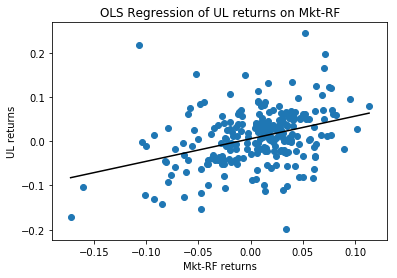

In [13]:
xx = np.linspace(min(X), max(X))
yy = np.array(b_ols[1]*xx + b_ols[0])[0]

plt.plot(xx,yy,'k-')
plt.xlabel("Mkt-RF returns")
plt.ylabel("UL returns")
plt.title("OLS Regression of UL returns on Mkt-RF")
plt.scatter(X,Y,cmap=plt.cm.Paired)

### (c). ###
Compute the variance-covariance matrix of the OLS coefficients under the assumption of homoskedasticity.

In [14]:
sigma_squared = np.var(epsilon)
V_homo = np.linalg.inv(xTx)*sigma_squared
V_homo

matrix([[ 1.49621933e-05, -4.50809579e-05],
        [-4.50809579e-05,  7.24107629e-03]])

### (d). ###
Use t-tests to test the null hypothesis that each regression coefficient is individually equal to 0.

In [15]:
std_error = np.sqrt(np.linalg.inv(xTx)*sigma_squared)
where_are_NaNs_1 = isnan(std_error)
std_error[where_are_NaNs_1] = 0  # fill nan
std_error

/Users/leichunyan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


matrix([[0.0038681 , 0.        ],
        [0.        , 0.08509451]])

In [16]:
t_value = b_ols/std_error

level={0.1:0.95, 0.05:0.975,0.01:0.995}
df=n-k-1
for i in range(xMat.shape[1]):
    if i == 0:
        print("alpha:")
    elif i == 1:
        print("beta:")
    elif i == 2:
        print("gamma")
    for key, value in level.items():
        if abs(t_value[i,i]) > t.ppf(value, df):
            print("%d%% : significant      "% (key*100) , end=" ")
        else:
            print("%d%% : not significant  "% (key*100), end=" ")
    print()

alpha:
10% : not significant   5% : not significant   1% : not significant   
beta:
10% : significant       5% : significant       1% : significant       


/Users/leichunyan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


From the p value calculated above, we can find that $\alpha$ is not significantly different than 0 at all confidence levels, <br/> $\beta$ is significantly different than 0 at all confidence levels.

### (e). ###
Assess whether there is significant evidence for heteroskedasticity.

White test  
(1) Run a regression
$$ 
\hat{u_t}^2 = \alpha_1 + \alpha_2x_t + \alpha_3 x_t^2 +v_t
$$

In [17]:
data["(Mkt-RF)^2"] = X*X
X_white = data[["Mkt-RF","(Mkt-RF)^2"]]
xMat_white = np.mat(X_white).T
intercept = np.ones((X_white.shape[0], 1))
xMat_white = np.concatenate((intercept, xMat_white.T), axis = 1)
xTx_white = xMat_white.transpose()*xMat_white #X'X

yMat_white = np.square(epsilon)
b_ols_white = np.linalg.inv(xTx_white)*xMat_white.transpose()*yMat_white

(2) calculate $R^2$

In [18]:
y_hat_white = np.dot(xMat_white, b_ols_white)
epsilon_white = yMat_white - y_hat_white

spread_white = yMat_white - yMat_white.mean()

Rsquared_white = 1 - np.sum(np.square(epsilon_white))/np.sum(np.square(spread_white))

print("R-squared is %.4f" % Rsquared_white)

R-squared is 0.0286


(3). whether $nR^2 \sim \chi_{df}^2$  

In [19]:
n = xMat_white.shape[0]
stats_white = n * Rsquared_white
print("The white test statistics is %.6f" % stats_white)

for i in [0.01,0.05,0.1]:
    if stats_white<chi2.ppf(i,2):
        print("There is heteroskedasticity at", i*100,"% level")
    else:
        print("There is heteroskedasticity at", i*100,"% level")

The white test statistics is 6.901288
There is heteroskedasticity at 1.0 % level
There is heteroskedasticity at 5.0 % level
There is heteroskedasticity at 10.0 % level


### (f). ###
Compute standard errors and the 90%, 95% and 99% confidence intervals under the assumption of homoskedasticity.

In [20]:
print("              Confidence Interval            ")
print("----------------------------------------------")
print("            90%           95%           99%")
print("alpha  %.2f, %.2f   %.2f, %.2f   %.2f, %.2f"% 
      (b_ols[0,0]-1.65*std_error[0,0], b_ols[0,0]+1.65*std_error[0,0],
       b_ols[0,0]-1.96*std_error[0,0], b_ols[0,0]+1.96*std_error[0,0],
       b_ols[0,0]-2.33*std_error[0,0], b_ols[0,0]+2.33*std_error[0,0],
      ))
print("beta    %.2f, %.2f    %.2f, %.2f    %.2f, %.2f"% 
      (b_ols[1,0]-1.65*std_error[1,1], b_ols[1,0]+1.65*std_error[1,1],
       b_ols[1,0]-1.96*std_error[1,1], b_ols[1,0]+1.96*std_error[1,1],
       b_ols[1,0]-2.33*std_error[1,1], b_ols[1,0]+2.33*std_error[1,1],
      ))

              Confidence Interval            
----------------------------------------------
            90%           95%           99%
alpha  -0.00, 0.01   -0.00, 0.01   -0.00, 0.01
beta    0.37, 0.65    0.34, 0.68    0.31, 0.71


### (g). ###
Compute the variance-covariance matrix of the OLS coefficients under the assumption of heteroskedas- ticity.

In [21]:
tmp = np.sum(xMat*xMat.transpose()* np.square(epsilon))
V_hetero = np.linalg.inv(xTx)*tmp*np.linalg.inv(xTx)
V_hetero

matrix([[ 3.70347829e-02, -5.36948486e+00],
        [-5.36948486e+00,  8.60722167e+02]])

### (h). ###
Compute standard errors and the 90%, 95% and 99% confidence intervals using the White variance- covariance matrix.

In [22]:
std_error_hetero = np.sqrt(V_hetero)
where_are_NaNs_2 = isnan(std_error_hetero)
std_error_hetero[where_are_NaNs_2] = 0  # fill nan
std_error_hetero

/Users/leichunyan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


matrix([[ 0.19244423,  0.        ],
        [ 0.        , 29.33806686]])

In [23]:
print("          Confidence Interval(Hetero)            ")
print("-------------------------------------------------")
print("            90%           95%            99%")
print("alpha  %.2f, %.2f   %.2f, %.2f    %.2f, %.2f"% 
      (b_ols[0,0]-1.65*std_error_hetero[0,0], b_ols[0,0]+1.65*std_error_hetero[0,0],
       b_ols[0,0]-1.96*std_error_hetero[0,0], b_ols[0,0]+1.96*std_error_hetero[0,0],
       b_ols[0,0]-2.33*std_error_hetero[0,0], b_ols[0,0]+2.33*std_error_hetero[0,0],
      ))
print("beta  %.2f, %.2f  %.2f, %.2f  %.2f, %.2f"% 
      (b_ols[1,0]-1.65*std_error_hetero[1,1], b_ols[1,0]+1.65*std_error_hetero[1,1],
       b_ols[1,0]-1.96*std_error_hetero[1,1], b_ols[1,0]+1.96*std_error_hetero[1,1],
       b_ols[1,0]-2.33*std_error_hetero[1,1], b_ols[1,0]+2.33*std_error_hetero[1,1],
      ))

          Confidence Interval(Hetero)            
-------------------------------------------------
            90%           95%            99%
alpha  -0.31, 0.32   -0.37, 0.38    -0.44, 0.45
beta  -47.90, 48.92  -56.99, 58.01  -67.85, 68.87


### (i). ###
Use t-tests to test the null hypothesis that each regression coefficient is individually equal to 0 under the assumption of heteroskedasticity.

In [24]:
tvalue = (b_ols)/std_error_hetero
level={0.1:0.95, 0.05:0.975,0.01:0.995}
df=n-k-1
for i in range(xMat.shape[1]):
    if i == 0:
        print("alpha:")
    elif i == 1:
        print("beta:")
    elif i == 2:
        print("gamma")
    for key, value in level.items():
        if abs(t_value[i,i]) > t.ppf(value, df):
            print("%d%% : significant      "% (key*100) , end=" ")
        else:
            print("%d%% : not significant  "% (key*100), end=" ")
    print()

alpha:
10% : not significant   5% : not significant   1% : not significant   
beta:
10% : significant       5% : significant       1% : significant       


/Users/leichunyan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


From the p-value calculated above, we know that under the assumption of heteroskedasticity,$\beta$ is significantly different than 0,$\alpha$ is not significantly different than 0.

### (j). ###
Compute the AIC, BIC and Hannah-Quinn ICs.

In [25]:
logLike = -n/2*(np.log(2*math.pi)+1)-n/2*np.log(np.sum(sigma_squared)/n)
AIC = -2*logLike + 2*k
BIC = -2*logLike + 2*k*np.log(n)
HQIC = -2*logLike + 2*k*log(log(n))  # Hannah-Quinn IC

print("AIC:  %.4f"%AIC)
print("BIC:  %.4f"%BIC)
print("HQIC: %.4f"%HQIC)

AIC:  -1994.1414
BIC:  -1976.2022
HQIC: -1991.3335


### (k). ###
Compute the Durbin-Watson and Breusch-Godfrey test statistics. What do these tests tell you?

$$
DW = \frac{\sum_{t=2}^T(\hat{u}_t-\hat{u}_{t-1})^2}{\sum_{t=2}^T\hat{u_t}^2}
$$

___Durbin-Watson___

In [26]:
epsilon_df = pd.DataFrame([epsilon[i,0] for i in range(epsilon.shape[0])])
DW = np.sum(np.square(epsilon_df.diff().dropna())/np.sum(np.square(epsilon[1:])))

DW is around 2 means there is no autocorrelation.

___Breusch-Godfrey___

(1). Run a regression
$$
u_t = \rho_1 u_{t-1} + \rho_2 u_{t-2}+v_t
$$

In [27]:
u_lag1 = np.matrix(epsilon_df.shift(1).fillna(0))
u_lag2 = np.matrix(epsilon_df.shift(2).fillna(0))

In [28]:
u_lag = np.concatenate((u_lag1, u_lag2),axis=1)
uTu = u_lag.transpose()*u_lag
b_ols_u = np.linalg.inv(uTu)*u_lag.transpose()*epsilon

u_hat = np.dot(u_lag, b_ols_u)
u_vt = epsilon - u_hat

spread_u = epsilon - epsilon.mean()

Rsquared_u = 1 - np.sum(np.square(u_vt))/np.sum(np.square(spread_u))
#print("R-squared is %.4f" % Rsquared_u)
BG = (epsilon.shape[0] - 2)*Rsquared_u
print("Breusch-Godfrey test statistics is %.4f"%BG)

for i in [0.01,0.05,0.1]:
    if BG<chi2.ppf(i,2):
        print("There is no autocorrelation",i*100,"% level")
    else:
        print("The is no autocorrelation at",i*100,"% level")

Breusch-Godfrey test statistics is 0.6225
The is no autocorrelation at 1.0 % level
The is no autocorrelation at 5.0 % level
The is no autocorrelation at 10.0 % level


### (i). ###
Use QQ plots and formal tests to check whether the errors normally distributed.

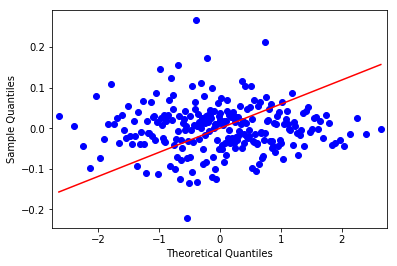

In [29]:
## QQ plot
sm.qqplot(epsilon, line='s')
pylab.show()

In [31]:
# Jarque-Bera (JB) test
import scipy.stats as stats
JB = n/6 *(np.power(stats.skew(epsilon),2) + np.power(stats.kurtosis(epsilon), 3)/4)
print("JB statistics is %.4f"%JB)
for i in [0.01,0.05,0.1]:
    if JB<chi2.ppf(i,2):
        print("The errors are normally distributed at",i*100,"% level")
    else:
        print("The errors are not normally distributed at",i*100,"% level")

JB statistics is 140.8859
The errors are not normally distributed at 1.0 % level
The errors are not normally distributed at 5.0 % level
The errors are not normally distributed at 10.0 % level


### (m). ###
Check whether the regressions exhibit multicollinearity.

In [32]:
if k-1 == 1: # since there is a constant
    print("There is no multicolinearity")
else:
    print("Please judge by correlation matrix")
    print("np.corrcoef(X)")

There is no multicolinearity


### (n). ###
Check whether there is evidence against the linear model specification.

In [33]:
X_ramsy = np.concatenate((xMat, np.square(y_hat),np.power(y_hat,3)), axis = 1)
xTx_ramsy = X_ramsy.transpose()*X_ramsy #X'X
b_ols_ramsy = np.linalg.inv(xTx_ramsy)*X_ramsy.transpose()*yMat

y_hat_ramsy = np.dot(xMat, b_ols)
epsilon_ramsy = yMat - y_hat_ramsy

sigma_square_ramsy = np.sum(np.square(epsilon_ramsy))/(n-k-1)

V_ramsy = np.linalg.inv(xTx_ramsy)*sigma_square_ramsy
t_ramsy = b_ols_ramsy/np.sqrt(V_ramsy.diagonal()).transpose()

# two-side
level={0.1:0.95, 0.05:0.975,0.01:0.995}
df=n-k-1
for i in range(X_ramsy.shape[1]):
    print("Ramsy test:")
    print("beta %d = %.4f" %(i, b_ols_ramsy[i]))
    for key, value in level.items():
        if abs(t_ramsy[i,0]) > t.ppf(value, df):
            print("%d%% : significant      "% (key*100) , end=" ")
        else:
            print("%d%% : not significant  "% (key*100), end=" ")
    print()

Ramsy test:
beta 0 = 0.0047
10% : not significant   5% : not significant   1% : not significant   
Ramsy test:
beta 1 = 0.3599
10% : significant       5% : significant       1% : significant       
Ramsy test:
beta 2 = 1.5690
10% : not significant   5% : not significant   1% : not significant   
Ramsy test:
beta 3 = 151.5220
10% : not significant   5% : not significant   1% : not significant   


Only the coefficient of the linear item is significant, which means there is no evidence against the linear model specification.

### (o). ###
Run rolling regressions with 60-month windows and plot the β coefficients along with their 95% confidence intervals. What do you learn from these regressions?

In [34]:
data["alpha_rolling"] = ''
data["beta_rolling"] = ''
for i in range(n-60):
    
    xMat_r = xMat[i:i+60] # r means rolling
    yMat_r = yMat[i:i+60]
    
    xTx_r = xMat_r.transpose()*xMat_r #X'X
    b_ols_r = np.linalg.inv(xTx_r)*xMat_r.transpose()*yMat_r
    
    data.iloc[i+60,7] = b_ols_r[0,0]
    data.iloc[i+60,8] = b_ols_r[1,0]

Text(0.5,1,'coefficient alpha')

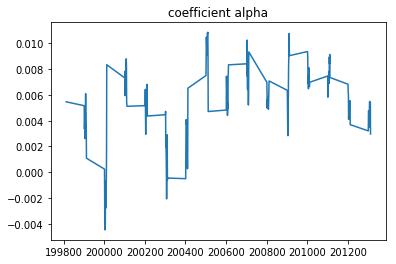

In [35]:
plt.plot(data.iloc[60:n,7])
plt.title("coefficient alpha")

Text(0.5,1,'coefficient beta')

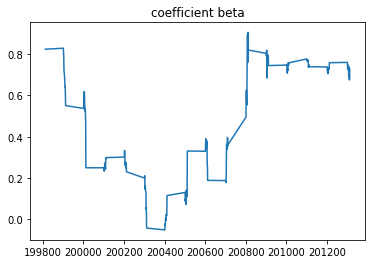

In [36]:
plt.plot(data.iloc[60:n,8])
plt.title("coefficient beta")

From the regression, we know that the coefficients are not stable.